# Library imports, setup

In [1]:
#if you change a file, you dont have to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from data import load_metadata, visualize_data, make_dataset
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss #custom loss function, currently not used

2025-11-30 20:40:49.687706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 20:40:49.769753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 20:40:50.952427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")

2.20.0
Found GPU /physical_device:GPU:0, and set memory growth to True.


# Loading data

In [4]:
image_metadata, species_metadata = load_metadata()
NUM_SPECIES = len(species_metadata)

Number of classes: 296


/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

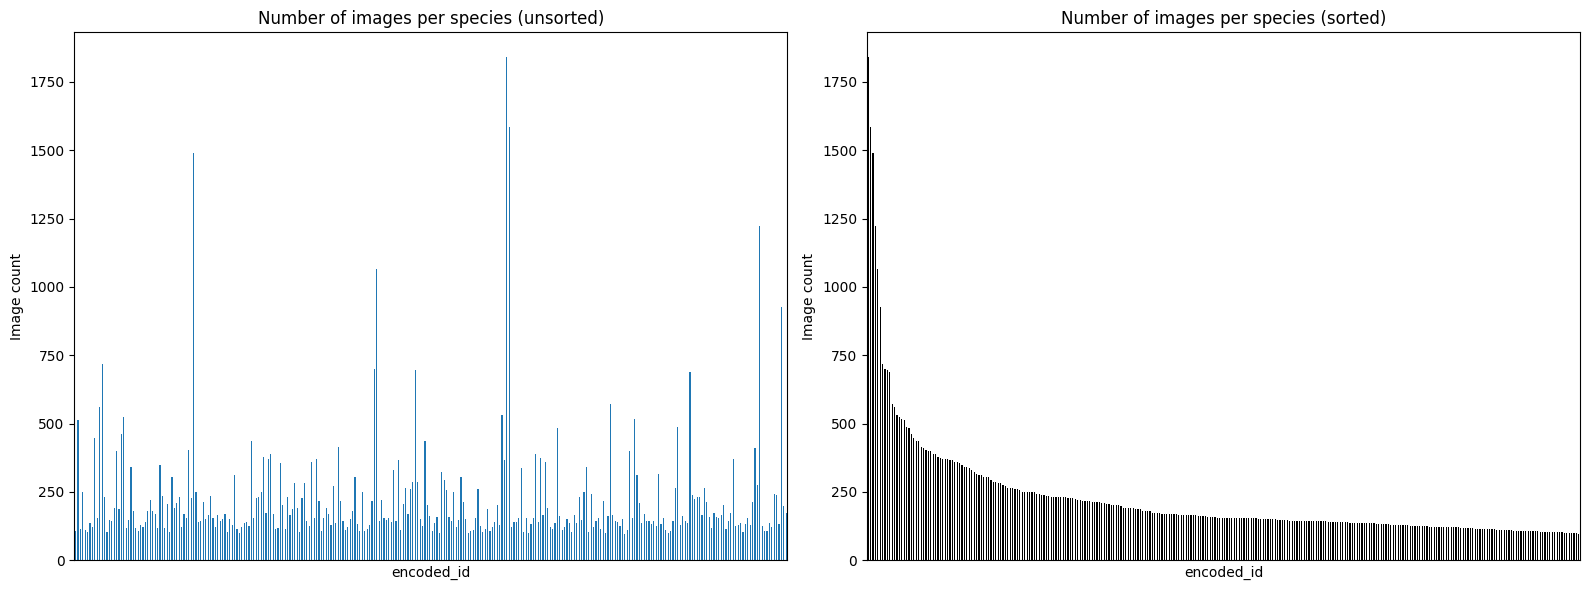

Maximum number per species class is 1839
Minimum number per species class is 96


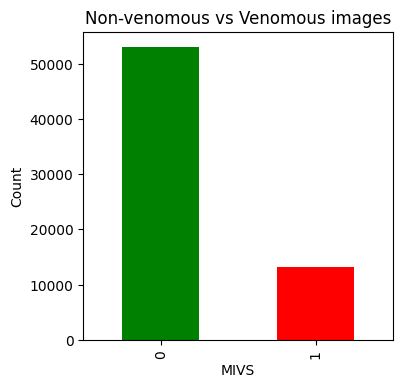

MIVS
0    53164
1    13290
Name: count, dtype: int64


In [5]:
#in data.py
visualize_data(image_metadata)

Loading python images from folder

# Building model

In [6]:
import tensorflow as tf
import keras

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
IMAGE_RESOLUTION=544
from data import make_batches, split_dataset

train_info, val_info = split_dataset(image_metadata)


species_classes = np.unique(train_info["encoded_id"])
species_cw = compute_class_weight(
    class_weight="balanced",
    classes=species_classes,
    y=train_info["encoded_id"],
)
species_cw_dict = {int(c): w for c, w in zip(species_classes, species_cw)}

species_weight_vec = tf.constant(
    [species_cw_dict[i] for i in range(len(species_cw_dict))],
    dtype=tf.float32,
)

#split dataset and make batches
train_dataset = make_batches(
    train_info,
    IMAGE_RESOLUTION,
    species_weight_vec=species_weight_vec,
)

val_dataset = make_batches(
    val_info,
    IMAGE_RESOLUTION,
    species_weight_vec=None,
)


I0000 00:00:1764531652.856538   23420 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model = build_multitask_model(num_species=NUM_SPECIES, image_resolution=IMAGE_RESOLUTION)
#print model summary optionally
#model.summary()

In [9]:
#compile the model with appropriate losses and metrics for each output

lr = 1e-4 #EfficientNetB0 recommends low learning rates

#TODO experiment with different optimizers
#TODO experiment with different losses

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        'binary_crossentropy'
    ],

    #need to balance the losses because species classification is harder than venom classification
    loss_weights=[1.0, 0.5],


    #only for monitoring during training
    metrics=['accuracy', 'accuracy'],
    )

In [10]:
import keras.callbacks

In [11]:
#Saves the model only when validation loss improves
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1, #print messages when saving
)

#training stops if no improvement in validation loss
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

#reduce learning rate when loss has stopped improving
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3, #multiply lr by this factor
    patience=3,
    min_lr=1e-6, #minimum lr
    verbose=1,
)


In [12]:
n_epochs = 100

class_weight = {
    "species": species_cw_dict,
    #"venom": venom_cw_dict,
}

#TODO currently not using any class weights
#we should experiment with using sample weights or class weights, or maybe Focal Loss

In [ ]:
model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=n_epochs,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    #class_weight=class_weight,
)

Epoch 1/100


2025-11-30 20:41:02.831017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 217/1662 ━━━━━━━━━━━━━━━━━━━━ 11:49 491ms/step - loss: 5.9690 - species_accuracy: 0.0074 - species_loss: 5.7136 - venom_accuracy: 0.7861 - venom_loss: 0.5107

2025-11-30 20:42:50.508518: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 700/1662 ━━━━━━━━━━━━━━━━━━━━ 7:43 482ms/step - loss: 5.8393 - species_accuracy: 0.0172 - species_loss: 5.6034 - venom_accuracy: 0.8029 - venom_loss: 0.4717

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 5.5996 - species_accuracy: 0.0359 - species_loss: 5.3754 - venom_accuracy: 0.8109 - venom_loss: 0.4484
Epoch 1: val_loss improved from None to 4.30628, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 920s 548ms/step - loss: 5.2020 - species_accuracy: 0.0647 - species_loss: 4.9903 - venom_accuracy: 0.8184 - venom_loss: 0.4236 - val_loss: 4.3063 - val_species_accuracy: 0.1725 - val_species_loss: 4.1168 - val_venom_accuracy: 0.8390 - val_venom_loss: 0.3796 - learning_rate: 1.0000e-04
Epoch 2/100
1434/1662 ━━━━━━━━━━━━━━━━━━━━ 1:49 479ms/step - loss: 4.3095 - species_accuracy: 0.1377 - species_loss: 4.1057 - venom_accuracy: 0.8255 - venom_loss: 0.4075

2025-11-30 21:07:41.349165: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1504/1662 ━━━━━━━━━━━━━━━━━━━━ 1:15 478ms/step - loss: 4.3040 - species_accuracy: 0.1382 - species_loss: 4.1004 - venom_accuracy: 0.8256 - venom_loss: 0.4072

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 4.2917 - species_accuracy: 0.1392 - species_loss: 4.0884 - venom_accuracy: 0.8258 - venom_loss: 0.4066
Epoch 2: val_loss improved from 4.30628 to 3.75068, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 880s 530ms/step - loss: 4.1649 - species_accuracy: 0.1501 - species_loss: 3.9638 - venom_accuracy: 0.8278 - venom_loss: 0.4008 - val_loss: 3.7507 - val_species_accuracy: 0.2414 - val_species_loss: 3.5685 - val_venom_accuracy: 0.8504 - val_venom_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 3/100
  71/1662 ━━━━━━━━━━━━━━━━━━━━ 12:09 458ms/step - loss: 3.8854 - species_accuracy: 0.1911 - species_loss: 3.6799 - venom_accuracy: 0.8260 - venom_loss: 0.4109

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1581/1662 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - loss: 3.8130 - species_accuracy: 0.1921 - species_loss: 3.6156 - venom_accuracy: 0.8278 - venom_loss: 0.3950

2025-11-30 21:22:57.749306: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 3.8107 - species_accuracy: 0.1922 - species_loss: 3.6133 - venom_accuracy: 0.8279 - venom_loss: 0.3947
Epoch 3: val_loss improved from 3.75068 to 3.49310, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 3.7596 - species_accuracy: 0.1959 - species_loss: 3.5648 - venom_accuracy: 0.8300 - venom_loss: 0.3899 - val_loss: 3.4931 - val_species_accuracy: 0.2716 - val_species_loss: 3.3122 - val_venom_accuracy: 0.8459 - val_venom_loss: 0.3604 - learning_rate: 1.0000e-04
Epoch 4/100
 365/1662 ━━━━━━━━━━━━━━━━━━━━ 9:51 456ms/step - loss: 3.5719 - species_accuracy: 0.2367 - species_loss: 3.3733 - venom_accuracy: 0.8281 - venom_loss: 0.3972

2025-11-30 21:27:51.036505: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1528/1662 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - loss: 3.5503 - species_accuracy: 0.2313 - species_loss: 3.3556 - venom_accuracy: 0.8327 - venom_loss: 0.3895

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 3.5478 - species_accuracy: 0.2312 - species_loss: 3.3533 - venom_accuracy: 0.8329 - venom_loss: 0.3890
Epoch 4: val_loss improved from 3.49310 to 3.33151, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 850s 512ms/step - loss: 3.5147 - species_accuracy: 0.2296 - species_loss: 3.3224 - venom_accuracy: 0.8350 - venom_loss: 0.3843 - val_loss: 3.3315 - val_species_accuracy: 0.2932 - val_species_loss: 3.1549 - val_venom_accuracy: 0.8497 - val_venom_loss: 0.3530 - learning_rate: 1.0000e-04
Epoch 5/100
 729/1662 ━━━━━━━━━━━━━━━━━━━━ 7:32 485ms/step - loss: 3.3681 - species_accuracy: 0.2487 - species_loss: 3.1806 - venom_accuracy: 0.8374 - venom_loss: 0.3749

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1013/1662 ━━━━━━━━━━━━━━━━━━━━ 5:17 490ms/step - loss: 3.3610 - species_accuracy: 0.2499 - species_loss: 3.1740 - venom_accuracy: 0.8381 - venom_loss: 0.3740

2025-11-30 21:47:31.035539: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 3.3519 - species_accuracy: 0.2518 - species_loss: 3.1646 - venom_accuracy: 0.8383 - venom_loss: 0.3746
Epoch 5: val_loss improved from 3.33151 to 3.23018, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 908s 546ms/step - loss: 3.3335 - species_accuracy: 0.2561 - species_loss: 3.1459 - venom_accuracy: 0.8386 - venom_loss: 0.3763 - val_loss: 3.2302 - val_species_accuracy: 0.3049 - val_species_loss: 3.0561 - val_venom_accuracy: 0.8534 - val_venom_loss: 0.3466 - learning_rate: 1.0000e-04
Epoch 6/100
 317/1662 ━━━━━━━━━━━━━━━━━━━━ 10:56 488ms/step - loss: 3.2032 - species_accuracy: 0.2680 - species_loss: 3.0088 - venom_accuracy: 0.8321 - venom_loss: 0.3889

2025-11-30 21:56:58.228826: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 628/1662 ━━━━━━━━━━━━━━━━━━━━ 8:12 476ms/step - loss: 3.2151 - species_accuracy: 0.2698 - species_loss: 3.0229 - venom_accuracy: 0.8345 - venom_loss: 0.3845

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.2104 - species_accuracy: 0.2727 - species_loss: 3.0213 - venom_accuracy: 0.8385 - venom_loss: 0.3782
Epoch 6: val_loss improved from 3.23018 to 3.13275, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 863s 519ms/step - loss: 3.1939 - species_accuracy: 0.2772 - species_loss: 3.0074 - venom_accuracy: 0.8402 - venom_loss: 0.3742 - val_loss: 3.1328 - val_species_accuracy: 0.3190 - val_species_loss: 2.9594 - val_venom_accuracy: 0.8548 - val_venom_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 7/100
 340/1662 ━━━━━━━━━━━━━━━━━━━━ 9:58 453ms/step - loss: 3.0928 - species_accuracy: 0.2896 - species_loss: 2.9008 - venom_accuracy: 0.8324 - venom_loss: 0.3840

2025-11-30 22:11:19.887046: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1424/1662 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - loss: 3.0899 - species_accuracy: 0.2916 - species_loss: 2.9046 - venom_accuracy: 0.8406 - venom_loss: 0.3707

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 3.0886 - species_accuracy: 0.2921 - species_loss: 2.9033 - venom_accuracy: 0.8407 - venom_loss: 0.3705
Epoch 7: val_loss improved from 3.13275 to 3.05432, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 841s 506ms/step - loss: 3.0782 - species_accuracy: 0.2954 - species_loss: 2.8942 - venom_accuracy: 0.8420 - venom_loss: 0.3691 - val_loss: 3.0543 - val_species_accuracy: 0.3300 - val_species_loss: 2.8827 - val_venom_accuracy: 0.8540 - val_venom_loss: 0.3430 - learning_rate: 1.0000e-04
Epoch 8/100
 643/1662 ━━━━━━━━━━━━━━━━━━━━ 7:40 452ms/step - loss: 2.9742 - species_accuracy: 0.3142 - species_loss: 2.7964 - venom_accuracy: 0.8500 - venom_loss: 0.3557

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1461/1662 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - loss: 2.9750 - species_accuracy: 0.3133 - species_loss: 2.7939 - venom_accuracy: 0.8460 - venom_loss: 0.3621

2025-11-30 22:33:48.518492: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 2.9756 - species_accuracy: 0.3132 - species_loss: 2.7942 - venom_accuracy: 0.8457 - venom_loss: 0.3628
Epoch 8: val_loss improved from 3.05432 to 2.97424, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 842s 506ms/step - loss: 2.9794 - species_accuracy: 0.3123 - species_loss: 2.7957 - venom_accuracy: 0.8435 - venom_loss: 0.3674 - val_loss: 2.9742 - val_species_accuracy: 0.3505 - val_species_loss: 2.8034 - val_venom_accuracy: 0.8561 - val_venom_loss: 0.3416 - learning_rate: 1.0000e-04
Epoch 9/100
 600/1662 ━━━━━━━━━━━━━━━━━━━━ 8:01 453ms/step - loss: 2.8755 - species_accuracy: 0.3271 - species_loss: 2.6933 - venom_accuracy: 0.8431 - venom_loss: 0.3643

2025-11-30 22:42:00.223760: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 963/1662 ━━━━━━━━━━━━━━━━━━━━ 5:16 453ms/step - loss: 2.8749 - species_accuracy: 0.3276 - species_loss: 2.6927 - venom_accuracy: 0.8432 - venom_loss: 0.3643

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 2.8811 - species_accuracy: 0.3274 - species_loss: 2.6987 - venom_accuracy: 0.8433 - venom_loss: 0.3647
Epoch 9: val_loss improved from 2.97424 to 2.92615, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 881s 506ms/step - loss: 2.8894 - species_accuracy: 0.3265 - species_loss: 2.7072 - venom_accuracy: 0.8443 - venom_loss: 0.3641 - val_loss: 2.9261 - val_species_accuracy: 0.3571 - val_species_loss: 2.7576 - val_venom_accuracy: 0.8578 - val_venom_loss: 0.3380 - learning_rate: 1.0000e-04
Epoch 10/100
 570/1662 ━━━━━━━━━━━━━━━━━━━━ 8:14 453ms/step - loss: 2.8122 - species_accuracy: 0.3402 - species_loss: 2.6321 - venom_accuracy: 0.8489 - venom_loss: 0.3601

2025-11-30 22:55:48.125197: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1558/1662 ━━━━━━━━━━━━━━━━━━━━ 48s 465ms/step - loss: 2.8107 - species_accuracy: 0.3392 - species_loss: 2.6304 - venom_accuracy: 0.8471 - venom_loss: 0.3606

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 2.8106 - species_accuracy: 0.3391 - species_loss: 2.6303 - venom_accuracy: 0.8470 - venom_loss: 0.3606
Epoch 10: val_loss improved from 2.92615 to 2.89718, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 866s 521ms/step - loss: 2.8094 - species_accuracy: 0.3378 - species_loss: 2.6295 - venom_accuracy: 0.8463 - venom_loss: 0.3603 - val_loss: 2.8972 - val_species_accuracy: 0.3630 - val_species_loss: 2.7264 - val_venom_accuracy: 0.8581 - val_venom_loss: 0.3406 - learning_rate: 1.0000e-04
Epoch 11/100
 416/1662 ━━━━━━━━━━━━━━━━━━━━ 9:38 465ms/step - loss: 2.7621 - species_accuracy: 0.3353 - species_loss: 2.5842 - venom_accuracy: 0.8490 - venom_loss: 0.3558

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 580/1662 ━━━━━━━━━━━━━━━━━━━━ 8:20 462ms/step - loss: 2.7529 - species_accuracy: 0.3387 - species_loss: 2.5751 - venom_accuracy: 0.8488 - venom_loss: 0.3556

2025-11-30 23:10:24.166320: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 2.7450 - species_accuracy: 0.3452 - species_loss: 2.5665 - venom_accuracy: 0.8468 - venom_loss: 0.3570
Epoch 11: val_loss improved from 2.89718 to 2.85265, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 879s 529ms/step - loss: 2.7451 - species_accuracy: 0.3487 - species_loss: 2.5656 - venom_accuracy: 0.8454 - venom_loss: 0.3586 - val_loss: 2.8526 - val_species_accuracy: 0.3720 - val_species_loss: 2.6829 - val_venom_accuracy: 0.8593 - val_venom_loss: 0.3369 - learning_rate: 1.0000e-04
Epoch 12/100
1361/1662 ━━━━━━━━━━━━━━━━━━━━ 2:25 483ms/step - loss: 2.6856 - species_accuracy: 0.3586 - species_loss: 2.5083 - venom_accuracy: 0.8473 - venom_loss: 0.3546

2025-11-30 23:31:32.662666: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1415/1662 ━━━━━━━━━━━━━━━━━━━━ 1:59 483ms/step - loss: 2.6854 - species_accuracy: 0.3588 - species_loss: 2.5081 - venom_accuracy: 0.8473 - venom_loss: 0.3546

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 2.6847 - species_accuracy: 0.3592 - species_loss: 2.5073 - venom_accuracy: 0.8474 - venom_loss: 0.3548
Epoch 12: val_loss improved from 2.85265 to 2.80641, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 898s 540ms/step - loss: 2.6791 - species_accuracy: 0.3621 - species_loss: 2.5010 - venom_accuracy: 0.8475 - venom_loss: 0.3563 - val_loss: 2.8064 - val_species_accuracy: 0.3795 - val_species_loss: 2.6381 - val_venom_accuracy: 0.8593 - val_venom_loss: 0.3355 - learning_rate: 1.0000e-04
Epoch 13/100
 113/1662 ━━━━━━━━━━━━━━━━━━━━ 12:34 487ms/step - loss: 2.5915 - species_accuracy: 0.3715 - species_loss: 2.4172 - venom_accuracy: 0.8487 - venom_loss: 0.3486

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 488/1662 ━━━━━━━━━━━━━━━━━━━━ 9:36 491ms/step - loss: 2.6104 - species_accuracy: 0.3714 - species_loss: 2.4329 - venom_accuracy: 0.8461 - venom_loss: 0.3550

2025-11-30 23:39:32.962289: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 2.6115 - species_accuracy: 0.3727 - species_loss: 2.4341 - venom_accuracy: 0.8476 - venom_loss: 0.3547
Epoch 13: val_loss improved from 2.80641 to 2.77367, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 902s 543ms/step - loss: 2.6199 - species_accuracy: 0.3709 - species_loss: 2.4429 - venom_accuracy: 0.8489 - venom_loss: 0.3548 - val_loss: 2.7737 - val_species_accuracy: 0.3856 - val_species_loss: 2.6080 - val_venom_accuracy: 0.8640 - val_venom_loss: 0.3311 - learning_rate: 1.0000e-04
Epoch 14/100
 676/1662 ━━━━━━━━━━━━━━━━━━━━ 7:56 483ms/step - loss: 2.5568 - species_accuracy: 0.3856 - species_loss: 2.3822 - venom_accuracy: 0.8495 - venom_loss: 0.3493

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1431/1662 ━━━━━━━━━━━━━━━━━━━━ 1:52 485ms/step - loss: 2.5586 - species_accuracy: 0.3848 - species_loss: 2.3840 - venom_accuracy: 0.8499 - venom_loss: 0.3492

2025-12-01 00:02:09.616203: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 2.5588 - species_accuracy: 0.3845 - species_loss: 2.3840 - venom_accuracy: 0.8498 - venom_loss: 0.3496
Epoch 14: val_loss improved from 2.77367 to 2.73699, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 898s 540ms/step - loss: 2.5597 - species_accuracy: 0.3822 - species_loss: 2.3835 - venom_accuracy: 0.8490 - venom_loss: 0.3519 - val_loss: 2.7370 - val_species_accuracy: 0.3947 - val_species_loss: 2.5687 - val_venom_accuracy: 0.8590 - val_venom_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 15/100
 690/1662 ━━━━━━━━━━━━━━━━━━━━ 7:24 458ms/step - loss: 2.5100 - species_accuracy: 0.3971 - species_loss: 2.3369 - venom_accuracy: 0.8522 - venom_loss: 0.3463

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 962/1662 ━━━━━━━━━━━━━━━━━━━━ 5:20 457ms/step - loss: 2.5111 - species_accuracy: 0.3955 - species_loss: 2.3380 - venom_accuracy: 0.8520 - venom_loss: 0.3462

2025-12-01 00:12:53.037397: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 2.5098 - species_accuracy: 0.3936 - species_loss: 2.3361 - venom_accuracy: 0.8512 - venom_loss: 0.3475
Epoch 15: val_loss improved from 2.73699 to 2.72179, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 850s 511ms/step - loss: 2.5128 - species_accuracy: 0.3882 - species_loss: 2.3371 - venom_accuracy: 0.8492 - venom_loss: 0.3518 - val_loss: 2.7218 - val_species_accuracy: 0.3884 - val_species_loss: 2.5553 - val_venom_accuracy: 0.8619 - val_venom_loss: 0.3313 - learning_rate: 1.0000e-04
Epoch 16/100
 534/1662 ━━━━━━━━━━━━━━━━━━━━ 8:33 455ms/step - loss: 2.4555 - species_accuracy: 0.3976 - species_loss: 2.2809 - venom_accuracy: 0.8507 - venom_loss: 0.3492

2025-12-01 00:23:45.896744: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 933/1662 ━━━━━━━━━━━━━━━━━━━━ 5:32 456ms/step - loss: 2.4552 - species_accuracy: 0.3978 - species_loss: 2.2798 - venom_accuracy: 0.8499 - venom_loss: 0.3507

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.4551 - species_accuracy: 0.3979 - species_loss: 2.2799 - venom_accuracy: 0.8499 - venom_loss: 0.3504
Epoch 16: val_loss improved from 2.72179 to 2.70904, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 509ms/step - loss: 2.4653 - species_accuracy: 0.3967 - species_loss: 2.2902 - venom_accuracy: 0.8500 - venom_loss: 0.3504 - val_loss: 2.7090 - val_species_accuracy: 0.3941 - val_species_loss: 2.5433 - val_venom_accuracy: 0.8638 - val_venom_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 17/100
1045/1662 ━━━━━━━━━━━━━━━━━━━━ 4:42 457ms/step - loss: 2.4022 - species_accuracy: 0.4066 - species_loss: 2.2295 - venom_accuracy: 0.8526 - venom_loss: 0.3454

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1405/1662 ━━━━━━━━━━━━━━━━━━━━ 1:57 457ms/step - loss: 2.4057 - species_accuracy: 0.4066 - species_loss: 2.2327 - venom_accuracy: 0.8521 - venom_loss: 0.3460

2025-12-01 00:44:31.564202: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.4073 - species_accuracy: 0.4067 - species_loss: 2.2342 - venom_accuracy: 0.8519 - venom_loss: 0.3462
Epoch 17: val_loss improved from 2.70904 to 2.68611, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 2.4179 - species_accuracy: 0.4062 - species_loss: 2.2441 - venom_accuracy: 0.8504 - venom_loss: 0.3476 - val_loss: 2.6861 - val_species_accuracy: 0.4021 - val_species_loss: 2.5192 - val_venom_accuracy: 0.8620 - val_venom_loss: 0.3331 - learning_rate: 1.0000e-04
Epoch 18/100
1164/1662 ━━━━━━━━━━━━━━━━━━━━ 3:47 456ms/step - loss: 2.3514 - species_accuracy: 0.4169 - species_loss: 2.1812 - venom_accuracy: 0.8558 - venom_loss: 0.3403

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1474/1662 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - loss: 2.3551 - species_accuracy: 0.4164 - species_loss: 2.1845 - venom_accuracy: 0.8552 - venom_loss: 0.3412

2025-12-01 00:59:10.984297: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.3572 - species_accuracy: 0.4160 - species_loss: 2.1864 - venom_accuracy: 0.8550 - venom_loss: 0.3416
Epoch 18: val_loss improved from 2.68611 to 2.66450, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 510ms/step - loss: 2.3731 - species_accuracy: 0.4132 - species_loss: 2.2004 - venom_accuracy: 0.8536 - venom_loss: 0.3450 - val_loss: 2.6645 - val_species_accuracy: 0.4066 - val_species_loss: 2.5005 - val_venom_accuracy: 0.8631 - val_venom_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 19/100
 607/1662 ━━━━━━━━━━━━━━━━━━━━ 8:01 457ms/step - loss: 2.3229 - species_accuracy: 0.4230 - species_loss: 2.1513 - venom_accuracy: 0.8523 - venom_loss: 0.3432

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 703/1662 ━━━━━━━━━━━━━━━━━━━━ 7:17 456ms/step - loss: 2.3232 - species_accuracy: 0.4233 - species_loss: 2.1513 - venom_accuracy: 0.8521 - venom_loss: 0.3438

2025-12-01 01:07:27.571626: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.3292 - species_accuracy: 0.4229 - species_loss: 2.1566 - venom_accuracy: 0.8513 - venom_loss: 0.3452
Epoch 19: val_loss improved from 2.66450 to 2.63328, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 2.3394 - species_accuracy: 0.4221 - species_loss: 2.1656 - venom_accuracy: 0.8506 - venom_loss: 0.3470 - val_loss: 2.6333 - val_species_accuracy: 0.4129 - val_species_loss: 2.4680 - val_venom_accuracy: 0.8632 - val_venom_loss: 0.3289 - learning_rate: 1.0000e-04
Epoch 20/100
 615/1662 ━━━━━━━━━━━━━━━━━━━━ 7:58 457ms/step - loss: 2.2404 - species_accuracy: 0.4374 - species_loss: 2.0715 - venom_accuracy: 0.8542 - venom_loss: 0.3378

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1347/1662 ━━━━━━━━━━━━━━━━━━━━ 2:23 456ms/step - loss: 2.2619 - species_accuracy: 0.4346 - species_loss: 2.0905 - venom_accuracy: 0.8528 - venom_loss: 0.3427

2025-12-01 01:26:29.205129: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.2675 - species_accuracy: 0.4338 - species_loss: 2.0960 - venom_accuracy: 0.8528 - venom_loss: 0.3431
Epoch 20: val_loss improved from 2.63328 to 2.62066, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 2.2913 - species_accuracy: 0.4301 - species_loss: 2.1192 - venom_accuracy: 0.8525 - venom_loss: 0.3445 - val_loss: 2.6207 - val_species_accuracy: 0.4153 - val_species_loss: 2.4575 - val_venom_accuracy: 0.8619 - val_venom_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 21/100
 937/1662 ━━━━━━━━━━━━━━━━━━━━ 5:30 456ms/step - loss: 2.2607 - species_accuracy: 0.4367 - species_loss: 2.0881 - venom_accuracy: 0.8539 - venom_loss: 0.3452

2025-12-01 01:37:30.972469: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1145/1662 ━━━━━━━━━━━━━━━━━━━━ 3:55 456ms/step - loss: 2.2584 - species_accuracy: 0.4364 - species_loss: 2.0861 - venom_accuracy: 0.8542 - venom_loss: 0.3446

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.2573 - species_accuracy: 0.4355 - species_loss: 2.0853 - venom_accuracy: 0.8544 - venom_loss: 0.3441
Epoch 21: val_loss improved from 2.62066 to 2.60523, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 2.2521 - species_accuracy: 0.4331 - species_loss: 2.0804 - venom_accuracy: 0.8543 - venom_loss: 0.3435 - val_loss: 2.6052 - val_species_accuracy: 0.4181 - val_species_loss: 2.4414 - val_venom_accuracy: 0.8656 - val_venom_loss: 0.3268 - learning_rate: 1.0000e-04
Epoch 22/100
 933/1662 ━━━━━━━━━━━━━━━━━━━━ 5:32 457ms/step - loss: 2.2029 - species_accuracy: 0.4454 - species_loss: 2.0268 - venom_accuracy: 0.8478 - venom_loss: 0.3522

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1269/1662 ━━━━━━━━━━━━━━━━━━━━ 2:59 457ms/step - loss: 2.2067 - species_accuracy: 0.4443 - species_loss: 2.0317 - venom_accuracy: 0.8493 - venom_loss: 0.3500

2025-12-01 01:54:10.225308: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.2101 - species_accuracy: 0.4437 - species_loss: 2.0359 - venom_accuracy: 0.8505 - venom_loss: 0.3483
Epoch 22: val_loss improved from 2.60523 to 2.58300, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 510ms/step - loss: 2.2210 - species_accuracy: 0.4412 - species_loss: 2.0498 - venom_accuracy: 0.8542 - venom_loss: 0.3424 - val_loss: 2.5830 - val_species_accuracy: 0.4239 - val_species_loss: 2.4200 - val_venom_accuracy: 0.8653 - val_venom_loss: 0.3249 - learning_rate: 1.0000e-04
Epoch 23/100
  11/1662 ━━━━━━━━━━━━━━━━━━━━ 12:14 445ms/step - loss: 2.3052 - species_accuracy: 0.4157 - species_loss: 2.1335 - venom_accuracy: 0.8598 - venom_loss: 0.3435

2025-12-01 01:58:43.942341: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 189/1662 ━━━━━━━━━━━━━━━━━━━━ 11:15 458ms/step - loss: 2.1287 - species_accuracy: 0.4481 - species_loss: 1.9650 - venom_accuracy: 0.8684 - venom_loss: 0.3274

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.1608 - species_accuracy: 0.4480 - species_loss: 1.9922 - venom_accuracy: 0.8585 - venom_loss: 0.3372
Epoch 23: val_loss improved from 2.58300 to 2.57617, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 2.1845 - species_accuracy: 0.4463 - species_loss: 2.0141 - venom_accuracy: 0.8547 - venom_loss: 0.3408 - val_loss: 2.5762 - val_species_accuracy: 0.4241 - val_species_loss: 2.4104 - val_venom_accuracy: 0.8638 - val_venom_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 24/100
 292/1662 ━━━━━━━━━━━━━━━━━━━━ 10:24 456ms/step - loss: 2.1503 - species_accuracy: 0.4629 - species_loss: 1.9783 - venom_accuracy: 0.8525 - venom_loss: 0.3440

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 813/1662 ━━━━━━━━━━━━━━━━━━━━ 6:26 456ms/step - loss: 2.1434 - species_accuracy: 0.4594 - species_loss: 1.9722 - venom_accuracy: 0.8539 - venom_loss: 0.3424

2025-12-01 02:18:57.484909: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 2.1415 - species_accuracy: 0.4569 - species_loss: 1.9712 - venom_accuracy: 0.8552 - venom_loss: 0.3406
Epoch 24: val_loss improved from 2.57617 to 2.55651, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 509ms/step - loss: 2.1441 - species_accuracy: 0.4538 - species_loss: 1.9744 - venom_accuracy: 0.8562 - venom_loss: 0.3394 - val_loss: 2.5565 - val_species_accuracy: 0.4281 - val_species_loss: 2.3944 - val_venom_accuracy: 0.8670 - val_venom_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 25/100
 341/1662 ━━━━━━━━━━━━━━━━━━━━ 10:04 457ms/step - loss: 2.0939 - species_accuracy: 0.4584 - species_loss: 1.9254 - venom_accuracy: 0.8525 - venom_loss: 0.3369

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1119/1662 ━━━━━━━━━━━━━━━━━━━━ 4:08 457ms/step - loss: 2.1026 - species_accuracy: 0.4590 - species_loss: 1.9335 - venom_accuracy: 0.8543 - venom_loss: 0.3381

2025-12-01 02:35:25.056252: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.1070 - species_accuracy: 0.4591 - species_loss: 1.9378 - venom_accuracy: 0.8546 - venom_loss: 0.3385
Epoch 25: val_loss improved from 2.55651 to 2.54356, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 2.1221 - species_accuracy: 0.4587 - species_loss: 1.9521 - venom_accuracy: 0.8544 - venom_loss: 0.3407 - val_loss: 2.5436 - val_species_accuracy: 0.4301 - val_species_loss: 2.3819 - val_venom_accuracy: 0.8677 - val_venom_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 26/100
 173/1662 ━━━━━━━━━━━━━━━━━━━━ 11:15 453ms/step - loss: 2.0330 - species_accuracy: 0.4776 - species_loss: 1.8776 - venom_accuracy: 0.8612 - venom_loss: 0.3108

2025-12-01 02:42:20.629800: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 870/1662 ━━━━━━━━━━━━━━━━━━━━ 6:02 457ms/step - loss: 2.0583 - species_accuracy: 0.4686 - species_loss: 1.8950 - venom_accuracy: 0.8587 - venom_loss: 0.3266

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.0734 - species_accuracy: 0.4665 - species_loss: 1.9079 - venom_accuracy: 0.8573 - venom_loss: 0.3310
Epoch 26: val_loss improved from 2.54356 to 2.53420, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 2.0899 - species_accuracy: 0.4632 - species_loss: 1.9212 - venom_accuracy: 0.8550 - venom_loss: 0.3369 - val_loss: 2.5342 - val_species_accuracy: 0.4307 - val_species_loss: 2.3721 - val_venom_accuracy: 0.8671 - val_venom_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 27/100
 505/1662 ━━━━━━━━━━━━━━━━━━━━ 8:47 456ms/step - loss: 2.0275 - species_accuracy: 0.4781 - species_loss: 1.8622 - venom_accuracy: 0.8572 - venom_loss: 0.3306

2025-12-01 02:59:00.483290: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1190/1662 ━━━━━━━━━━━━━━━━━━━━ 3:35 457ms/step - loss: 2.0448 - species_accuracy: 0.4742 - species_loss: 1.8771 - venom_accuracy: 0.8564 - venom_loss: 0.3354

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.0484 - species_accuracy: 0.4731 - species_loss: 1.8807 - venom_accuracy: 0.8569 - venom_loss: 0.3354
Epoch 27: val_loss improved from 2.53420 to 2.52860, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 2.0584 - species_accuracy: 0.4706 - species_loss: 1.8910 - venom_accuracy: 0.8576 - venom_loss: 0.3354 - val_loss: 2.5286 - val_species_accuracy: 0.4339 - val_species_loss: 2.3675 - val_venom_accuracy: 0.8673 - val_venom_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 28/100
 319/1662 ━━━━━━━━━━━━━━━━━━━━ 10:12 456ms/step - loss: 1.9996 - species_accuracy: 0.4737 - species_loss: 1.8297 - venom_accuracy: 0.8557 - venom_loss: 0.3397

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 849/1662 ━━━━━━━━━━━━━━━━━━━━ 6:11 457ms/step - loss: 2.0111 - species_accuracy: 0.4733 - species_loss: 1.8431 - venom_accuracy: 0.8559 - venom_loss: 0.3360

2025-12-01 03:15:46.764981: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.0172 - species_accuracy: 0.4733 - species_loss: 1.8492 - venom_accuracy: 0.8562 - venom_loss: 0.3360
Epoch 28: val_loss improved from 2.52860 to 2.50988, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 2.0332 - species_accuracy: 0.4736 - species_loss: 1.8650 - venom_accuracy: 0.8561 - venom_loss: 0.3365 - val_loss: 2.5099 - val_species_accuracy: 0.4352 - val_species_loss: 2.3501 - val_venom_accuracy: 0.8689 - val_venom_loss: 0.3192 - learning_rate: 1.0000e-04
Epoch 29/100
 256/1662 ━━━━━━━━━━━━━━━━━━━━ 10:44 458ms/step - loss: 1.9565 - species_accuracy: 0.4940 - species_loss: 1.7858 - venom_accuracy: 0.8641 - venom_loss: 0.3413

2025-12-01 03:25:23.609559: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1317/1662 ━━━━━━━━━━━━━━━━━━━━ 2:37 456ms/step - loss: 1.9756 - species_accuracy: 0.4860 - species_loss: 1.8083 - venom_accuracy: 0.8598 - venom_loss: 0.3347

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.9799 - species_accuracy: 0.4850 - species_loss: 1.8126 - venom_accuracy: 0.8594 - venom_loss: 0.3347
Epoch 29: val_loss improved from 2.50988 to 2.49763, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.9940 - species_accuracy: 0.4810 - species_loss: 1.8265 - venom_accuracy: 0.8577 - venom_loss: 0.3346 - val_loss: 2.4976 - val_species_accuracy: 0.4376 - val_species_loss: 2.3369 - val_venom_accuracy: 0.8662 - val_venom_loss: 0.3207 - learning_rate: 1.0000e-04
Epoch 30/100
  20/1662 ━━━━━━━━━━━━━━━━━━━━ 12:04 442ms/step - loss: 1.9512 - species_accuracy: 0.4991 - species_loss: 1.7894 - venom_accuracy: 0.8631 - venom_loss: 0.3235

2025-12-01 03:37:43.340491: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 506/1662 ━━━━━━━━━━━━━━━━━━━━ 8:47 456ms/step - loss: 1.9966 - species_accuracy: 0.4849 - species_loss: 1.8312 - venom_accuracy: 0.8572 - venom_loss: 0.3308

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.9771 - species_accuracy: 0.4855 - species_loss: 1.8110 - venom_accuracy: 0.8567 - venom_loss: 0.3323
Epoch 30: val_loss improved from 2.49763 to 2.47841, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 1.9721 - species_accuracy: 0.4842 - species_loss: 1.8047 - venom_accuracy: 0.8560 - venom_loss: 0.3344 - val_loss: 2.4784 - val_species_accuracy: 0.4462 - val_species_loss: 2.3171 - val_venom_accuracy: 0.8656 - val_venom_loss: 0.3218 - learning_rate: 1.0000e-04
Epoch 31/100
 761/1662 ━━━━━━━━━━━━━━━━━━━━ 6:50 456ms/step - loss: 1.9358 - species_accuracy: 0.4986 - species_loss: 1.7673 - venom_accuracy: 0.8548 - venom_loss: 0.3369

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1120/1662 ━━━━━━━━━━━━━━━━━━━━ 4:07 456ms/step - loss: 1.9370 - species_accuracy: 0.4960 - species_loss: 1.7687 - venom_accuracy: 0.8555 - venom_loss: 0.3366

2025-12-01 04:00:12.701607: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.9416 - species_accuracy: 0.4934 - species_loss: 1.7735 - venom_accuracy: 0.8561 - venom_loss: 0.3361
Epoch 31: val_loss did not improve from 2.47841
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 1.9536 - species_accuracy: 0.4877 - species_loss: 1.7861 - venom_accuracy: 0.8574 - venom_loss: 0.3352 - val_loss: 2.4838 - val_species_accuracy: 0.4417 - val_species_loss: 2.3252 - val_venom_accuracy: 0.8671 - val_venom_loss: 0.3206 - learning_rate: 1.0000e-04
Epoch 32/100
1381/1662 ━━━━━━━━━━━━━━━━━━━━ 2:08 456ms/step - loss: 1.9144 - species_accuracy: 0.4981 - species_loss: 1.7492 - venom_accuracy: 0.8586 - venom_loss: 0.3304

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1653/1662 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - loss: 1.9157 - species_accuracy: 0.4978 - species_loss: 1.7502 - venom_accuracy: 0.8582 - venom_loss: 0.3310

2025-12-01 04:18:23.566502: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.9158 - species_accuracy: 0.4978 - species_loss: 1.7503 - venom_accuracy: 0.8582 - venom_loss: 0.3310
Epoch 32: val_loss improved from 2.47841 to 2.47622, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 1.9240 - species_accuracy: 0.4955 - species_loss: 1.7568 - venom_accuracy: 0.8558 - venom_loss: 0.3343 - val_loss: 2.4762 - val_species_accuracy: 0.4454 - val_species_loss: 2.3197 - val_venom_accuracy: 0.8686 - val_venom_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 33/100
 354/1662 ━━━━━━━━━━━━━━━━━━━━ 9:58 457ms/step - loss: 1.8785 - species_accuracy: 0.5135 - species_loss: 1.7046 - venom_accuracy: 0.8433 - venom_loss: 0.3479

2025-12-01 04:22:39.367408: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1037/1662 ━━━━━━━━━━━━━━━━━━━━ 4:45 456ms/step - loss: 1.8829 - species_accuracy: 0.5087 - species_loss: 1.7137 - venom_accuracy: 0.8520 - venom_loss: 0.3386

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.8899 - species_accuracy: 0.5053 - species_loss: 1.7217 - venom_accuracy: 0.8540 - venom_loss: 0.3364
Epoch 33: val_loss improved from 2.47622 to 2.46666, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.9019 - species_accuracy: 0.4992 - species_loss: 1.7353 - venom_accuracy: 0.8575 - venom_loss: 0.3323 - val_loss: 2.4667 - val_species_accuracy: 0.4507 - val_species_loss: 2.3051 - val_venom_accuracy: 0.8670 - val_venom_loss: 0.3231 - learning_rate: 1.0000e-04
Epoch 34/100
 425/1662 ━━━━━━━━━━━━━━━━━━━━ 9:24 457ms/step - loss: 1.8799 - species_accuracy: 0.5098 - species_loss: 1.7161 - venom_accuracy: 0.8600 - venom_loss: 0.3276

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 497/1662 ━━━━━━━━━━━━━━━━━━━━ 8:51 456ms/step - loss: 1.8771 - species_accuracy: 0.5101 - species_loss: 1.7130 - venom_accuracy: 0.8595 - venom_loss: 0.3281

2025-12-01 04:37:51.740292: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.8672 - species_accuracy: 0.5078 - species_loss: 1.7021 - venom_accuracy: 0.8585 - venom_loss: 0.3301
Epoch 34: val_loss improved from 2.46666 to 2.45832, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 1.8688 - species_accuracy: 0.5041 - species_loss: 1.7035 - venom_accuracy: 0.8590 - venom_loss: 0.3305 - val_loss: 2.4583 - val_species_accuracy: 0.4464 - val_species_loss: 2.2988 - val_venom_accuracy: 0.8677 - val_venom_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 35/100
 859/1662 ━━━━━━━━━━━━━━━━━━━━ 6:05 455ms/step - loss: 1.8582 - species_accuracy: 0.5089 - species_loss: 1.6911 - venom_accuracy: 0.8547 - venom_loss: 0.3341

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1653/1662 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - loss: 1.8577 - species_accuracy: 0.5084 - species_loss: 1.6912 - venom_accuracy: 0.8558 - venom_loss: 0.3329

2025-12-01 05:00:47.446515: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.8576 - species_accuracy: 0.5084 - species_loss: 1.6912 - venom_accuracy: 0.8558 - venom_loss: 0.3328
Epoch 35: val_loss improved from 2.45832 to 2.44739, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.8562 - species_accuracy: 0.5076 - species_loss: 1.6906 - venom_accuracy: 0.8575 - venom_loss: 0.3311 - val_loss: 2.4474 - val_species_accuracy: 0.4512 - val_species_loss: 2.2873 - val_venom_accuracy: 0.8665 - val_venom_loss: 0.3195 - learning_rate: 1.0000e-04
Epoch 36/100
 852/1662 ━━━━━━━━━━━━━━━━━━━━ 6:10 457ms/step - loss: 1.8004 - species_accuracy: 0.5154 - species_loss: 1.6345 - venom_accuracy: 0.8586 - venom_loss: 0.3319

2025-12-01 05:08:50.836109: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1502/1662 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - loss: 1.8101 - species_accuracy: 0.5142 - species_loss: 1.6447 - venom_accuracy: 0.8591 - venom_loss: 0.3310

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.8118 - species_accuracy: 0.5140 - species_loss: 1.6464 - venom_accuracy: 0.8591 - venom_loss: 0.3307
Epoch 36: val_loss did not improve from 2.44739
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 1.8305 - species_accuracy: 0.5121 - species_loss: 1.6662 - venom_accuracy: 0.8595 - venom_loss: 0.3285 - val_loss: 2.4532 - val_species_accuracy: 0.4480 - val_species_loss: 2.2950 - val_venom_accuracy: 0.8668 - val_venom_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 37/100
 896/1662 ━━━━━━━━━━━━━━━━━━━━ 5:50 457ms/step - loss: 1.7953 - species_accuracy: 0.5152 - species_loss: 1.6288 - venom_accuracy: 0.8544 - venom_loss: 0.3330

2025-12-01 05:23:17.875091: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1121/1662 ━━━━━━━━━━━━━━━━━━━━ 4:07 457ms/step - loss: 1.7943 - species_accuracy: 0.5152 - species_loss: 1.6280 - venom_accuracy: 0.8551 - venom_loss: 0.3327

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.7952 - species_accuracy: 0.5154 - species_loss: 1.6292 - venom_accuracy: 0.8561 - venom_loss: 0.3320
Epoch 37: val_loss improved from 2.44739 to 2.43783, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.8024 - species_accuracy: 0.5153 - species_loss: 1.6371 - venom_accuracy: 0.8583 - venom_loss: 0.3300 - val_loss: 2.4378 - val_species_accuracy: 0.4534 - val_species_loss: 2.2788 - val_venom_accuracy: 0.8688 - val_venom_loss: 0.3169 - learning_rate: 1.0000e-04
Epoch 38/100
 210/1662 ━━━━━━━━━━━━━━━━━━━━ 11:01 456ms/step - loss: 1.7967 - species_accuracy: 0.5038 - species_loss: 1.6352 - venom_accuracy: 0.8625 - venom_loss: 0.3229

2025-12-01 05:32:12.359867: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 627/1662 ━━━━━━━━━━━━━━━━━━━━ 7:50 455ms/step - loss: 1.7924 - species_accuracy: 0.5110 - species_loss: 1.6304 - venom_accuracy: 0.8619 - venom_loss: 0.3241

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 1.7843 - species_accuracy: 0.5169 - species_loss: 1.6212 - venom_accuracy: 0.8611 - venom_loss: 0.3262
Epoch 38: val_loss improved from 2.43783 to 2.42111, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 509ms/step - loss: 1.7849 - species_accuracy: 0.5215 - species_loss: 1.6202 - venom_accuracy: 0.8590 - venom_loss: 0.3299 - val_loss: 2.4211 - val_species_accuracy: 0.4570 - val_species_loss: 2.2623 - val_venom_accuracy: 0.8662 - val_venom_loss: 0.3182 - learning_rate: 1.0000e-04
Epoch 39/100
 313/1662 ━━━━━━━━━━━━━━━━━━━━ 10:13 455ms/step - loss: 1.7650 - species_accuracy: 0.5259 - species_loss: 1.5977 - venom_accuracy: 0.8544 - venom_loss: 0.3345

2025-12-01 05:47:05.831694: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1217/1662 ━━━━━━━━━━━━━━━━━━━━ 3:23 457ms/step - loss: 1.7557 - species_accuracy: 0.5253 - species_loss: 1.5907 - venom_accuracy: 0.8573 - venom_loss: 0.3301

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.7571 - species_accuracy: 0.5246 - species_loss: 1.5925 - venom_accuracy: 0.8582 - venom_loss: 0.3292
Epoch 39: val_loss did not improve from 2.42111
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 1.7636 - species_accuracy: 0.5235 - species_loss: 1.6001 - venom_accuracy: 0.8608 - venom_loss: 0.3272 - val_loss: 2.4338 - val_species_accuracy: 0.4521 - val_species_loss: 2.2766 - val_venom_accuracy: 0.8683 - val_venom_loss: 0.3138 - learning_rate: 1.0000e-04
Epoch 40/100
 719/1662 ━━━━━━━━━━━━━━━━━━━━ 7:11 458ms/step - loss: 1.7026 - species_accuracy: 0.5342 - species_loss: 1.5390 - venom_accuracy: 0.8582 - venom_loss: 0.3271

2025-12-01 06:04:19.373044: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 891/1662 ━━━━━━━━━━━━━━━━━━━━ 5:52 457ms/step - loss: 1.7044 - species_accuracy: 0.5340 - species_loss: 1.5413 - venom_accuracy: 0.8588 - venom_loss: 0.3262

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.7167 - species_accuracy: 0.5323 - species_loss: 1.5539 - venom_accuracy: 0.8595 - venom_loss: 0.3257
Epoch 40: val_loss improved from 2.42111 to 2.41415, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.7362 - species_accuracy: 0.5302 - species_loss: 1.5727 - venom_accuracy: 0.8592 - venom_loss: 0.3271 - val_loss: 2.4142 - val_species_accuracy: 0.4599 - val_species_loss: 2.2571 - val_venom_accuracy: 0.8676 - val_venom_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 41/100
 306/1662 ━━━━━━━━━━━━━━━━━━━━ 10:17 455ms/step - loss: 1.7168 - species_accuracy: 0.5280 - species_loss: 1.5504 - venom_accuracy: 0.8541 - venom_loss: 0.3329

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 333/1662 ━━━━━━━━━━━━━━━━━━━━ 10:08 458ms/step - loss: 1.7157 - species_accuracy: 0.5286 - species_loss: 1.5496 - venom_accuracy: 0.8547 - venom_loss: 0.3322

2025-12-01 06:15:30.379352: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.7170 - species_accuracy: 0.5324 - species_loss: 1.5533 - venom_accuracy: 0.8590 - venom_loss: 0.3274
Epoch 41: val_loss did not improve from 2.41415
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 904s 544ms/step - loss: 1.7204 - species_accuracy: 0.5327 - species_loss: 1.5563 - venom_accuracy: 0.8595 - venom_loss: 0.3276 - val_loss: 2.4266 - val_species_accuracy: 0.4513 - val_species_loss: 2.2678 - val_venom_accuracy: 0.8685 - val_venom_loss: 0.3172 - learning_rate: 1.0000e-04
Epoch 42/100
 148/1662 ━━━━━━━━━━━━━━━━━━━━ 11:31 457ms/step - loss: 1.6263 - species_accuracy: 0.5414 - species_loss: 1.4564 - venom_accuracy: 0.8532 - venom_loss: 0.3397

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 565/1662 ━━━━━━━━━━━━━━━━━━━━ 8:21 457ms/step - loss: 1.6444 - species_accuracy: 0.5436 - species_loss: 1.4789 - venom_accuracy: 0.8583 - venom_loss: 0.3312

2025-12-01 06:32:20.086328: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.6760 - species_accuracy: 0.5409 - species_loss: 1.5120 - venom_accuracy: 0.8603 - venom_loss: 0.3281
Epoch 42: val_loss did not improve from 2.41415
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 510ms/step - loss: 1.6998 - species_accuracy: 0.5379 - species_loss: 1.5369 - venom_accuracy: 0.8603 - venom_loss: 0.3260 - val_loss: 2.4166 - val_species_accuracy: 0.4597 - val_species_loss: 2.2606 - val_venom_accuracy: 0.8679 - val_venom_loss: 0.3131 - learning_rate: 1.0000e-04
Epoch 43/100
 658/1662 ━━━━━━━━━━━━━━━━━━━━ 7:39 457ms/step - loss: 1.6576 - species_accuracy: 0.5429 - species_loss: 1.4968 - venom_accuracy: 0.8644 - venom_loss: 0.3217

2025-12-01 06:47:11.258258: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1131/1662 ━━━━━━━━━━━━━━━━━━━━ 4:02 457ms/step - loss: 1.6595 - species_accuracy: 0.5438 - species_loss: 1.4975 - venom_accuracy: 0.8628 - venom_loss: 0.3240

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.6625 - species_accuracy: 0.5434 - species_loss: 1.4999 - venom_accuracy: 0.8620 - venom_loss: 0.3252
Epoch 43: val_loss improved from 2.41415 to 2.40268, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 850s 511ms/step - loss: 1.6733 - species_accuracy: 0.5416 - species_loss: 1.5101 - venom_accuracy: 0.8604 - venom_loss: 0.3273 - val_loss: 2.4027 - val_species_accuracy: 0.4605 - val_species_loss: 2.2466 - val_venom_accuracy: 0.8679 - val_venom_loss: 0.3142 - learning_rate: 1.0000e-04
Epoch 44/100
 489/1662 ━━━━━━━━━━━━━━━━━━━━ 8:56 457ms/step - loss: 1.6680 - species_accuracy: 0.5473 - species_loss: 1.5117 - venom_accuracy: 0.8687 - venom_loss: 0.3126

2025-12-01 07:00:03.666191: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 648/1662 ━━━━━━━━━━━━━━━━━━━━ 7:43 457ms/step - loss: 1.6646 - species_accuracy: 0.5467 - species_loss: 1.5074 - venom_accuracy: 0.8678 - venom_loss: 0.3145

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.6585 - species_accuracy: 0.5457 - species_loss: 1.4984 - venom_accuracy: 0.8645 - venom_loss: 0.3204
Epoch 44: val_loss improved from 2.40268 to 2.40016, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.6604 - species_accuracy: 0.5429 - species_loss: 1.4977 - venom_accuracy: 0.8612 - venom_loss: 0.3254 - val_loss: 2.4002 - val_species_accuracy: 0.4622 - val_species_loss: 2.2416 - val_venom_accuracy: 0.8670 - val_venom_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 45/100
 569/1662 ━━━━━━━━━━━━━━━━━━━━ 8:19 457ms/step - loss: 1.6032 - species_accuracy: 0.5511 - species_loss: 1.4435 - venom_accuracy: 0.8628 - venom_loss: 0.3195

2025-12-01 07:14:48.173294: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 728/1662 ━━━━━━━━━━━━━━━━━━━━ 7:06 457ms/step - loss: 1.6053 - species_accuracy: 0.5517 - species_loss: 1.4456 - venom_accuracy: 0.8627 - venom_loss: 0.3195

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.6213 - species_accuracy: 0.5504 - species_loss: 1.4606 - venom_accuracy: 0.8615 - venom_loss: 0.3214
Epoch 45: val_loss improved from 2.40016 to 2.38563, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.6425 - species_accuracy: 0.5484 - species_loss: 1.4797 - venom_accuracy: 0.8592 - venom_loss: 0.3250 - val_loss: 2.3856 - val_species_accuracy: 0.4649 - val_species_loss: 2.2293 - val_venom_accuracy: 0.8695 - val_venom_loss: 0.3113 - learning_rate: 1.0000e-04
Epoch 46/100
 585/1662 ━━━━━━━━━━━━━━━━━━━━ 8:11 456ms/step - loss: 1.6247 - species_accuracy: 0.5476 - species_loss: 1.4575 - venom_accuracy: 0.8595 - venom_loss: 0.3345

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1204/1662 ━━━━━━━━━━━━━━━━━━━━ 3:29 457ms/step - loss: 1.6176 - species_accuracy: 0.5500 - species_loss: 1.4523 - venom_accuracy: 0.8605 - venom_loss: 0.3307

2025-12-01 07:33:47.122021: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.6176 - species_accuracy: 0.5502 - species_loss: 1.4531 - venom_accuracy: 0.8610 - venom_loss: 0.3289
Epoch 46: val_loss did not improve from 2.38563
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 853s 513ms/step - loss: 1.6188 - species_accuracy: 0.5498 - species_loss: 1.4569 - venom_accuracy: 0.8623 - venom_loss: 0.3244 - val_loss: 2.3970 - val_species_accuracy: 0.4671 - val_species_loss: 2.2400 - val_venom_accuracy: 0.8673 - val_venom_loss: 0.3158 - learning_rate: 1.0000e-04
Epoch 47/100
 799/1662 ━━━━━━━━━━━━━━━━━━━━ 6:37 461ms/step - loss: 1.5768 - species_accuracy: 0.5568 - species_loss: 1.4150 - venom_accuracy: 0.8629 - venom_loss: 0.3235

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1380/1662 ━━━━━━━━━━━━━━━━━━━━ 2:09 459ms/step - loss: 1.5849 - species_accuracy: 0.5550 - species_loss: 1.4232 - venom_accuracy: 0.8627 - venom_loss: 0.3233

2025-12-01 07:49:23.417949: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 1.5888 - species_accuracy: 0.5544 - species_loss: 1.4271 - venom_accuracy: 0.8626 - venom_loss: 0.3234
Epoch 47: val_loss improved from 2.38563 to 2.38226, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 853s 513ms/step - loss: 1.6104 - species_accuracy: 0.5513 - species_loss: 1.4487 - venom_accuracy: 0.8626 - venom_loss: 0.3235 - val_loss: 2.3823 - val_species_accuracy: 0.4658 - val_species_loss: 2.2259 - val_venom_accuracy: 0.8680 - val_venom_loss: 0.3130 - learning_rate: 1.0000e-04
Epoch 48/100
 427/1662 ━━━━━━━━━━━━━━━━━━━━ 9:24 457ms/step - loss: 1.5521 - species_accuracy: 0.5623 - species_loss: 1.3929 - venom_accuracy: 0.8673 - venom_loss: 0.3184

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1375/1662 ━━━━━━━━━━━━━━━━━━━━ 2:11 457ms/step - loss: 1.5671 - species_accuracy: 0.5603 - species_loss: 1.4076 - venom_accuracy: 0.8658 - venom_loss: 0.3189

2025-12-01 08:03:31.127887: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.5710 - species_accuracy: 0.5593 - species_loss: 1.4114 - venom_accuracy: 0.8654 - venom_loss: 0.3193
Epoch 48: val_loss did not improve from 2.38226
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 510ms/step - loss: 1.5937 - species_accuracy: 0.5540 - species_loss: 1.4334 - venom_accuracy: 0.8630 - venom_loss: 0.3214 - val_loss: 2.3830 - val_species_accuracy: 0.4689 - val_species_loss: 2.2276 - val_venom_accuracy: 0.8665 - val_venom_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 49/100
 408/1662 ━━━━━━━━━━━━━━━━━━━━ 9:34 458ms/step - loss: 1.5212 - species_accuracy: 0.5799 - species_loss: 1.3622 - venom_accuracy: 0.8666 - venom_loss: 0.3180

2025-12-01 08:10:17.036987: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1070/1662 ━━━━━━━━━━━━━━━━━━━━ 4:30 457ms/step - loss: 1.5383 - species_accuracy: 0.5737 - species_loss: 1.3790 - venom_accuracy: 0.8649 - venom_loss: 0.3186

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.5480 - species_accuracy: 0.5705 - species_loss: 1.3884 - venom_accuracy: 0.8642 - venom_loss: 0.3192
Epoch 49: val_loss did not improve from 2.38226
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 1.5678 - species_accuracy: 0.5638 - species_loss: 1.4074 - venom_accuracy: 0.8626 - venom_loss: 0.3208 - val_loss: 2.3887 - val_species_accuracy: 0.4674 - val_species_loss: 2.2307 - val_venom_accuracy: 0.8688 - val_venom_loss: 0.3158 - learning_rate: 1.0000e-04
Epoch 50/100
 420/1662 ━━━━━━━━━━━━━━━━━━━━ 9:23 453ms/step - loss: 1.4957 - species_accuracy: 0.5789 - species_loss: 1.3336 - venom_accuracy: 0.8601 - venom_loss: 0.3243

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1440/1662 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - loss: 1.5214 - species_accuracy: 0.5716 - species_loss: 1.3589 - venom_accuracy: 0.8611 - venom_loss: 0.3250

2025-12-01 08:32:14.539597: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 1.5247 - species_accuracy: 0.5705 - species_loss: 1.3624 - venom_accuracy: 0.8614 - venom_loss: 0.3246
Epoch 50: val_loss improved from 2.38226 to 2.37770, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.5508 - species_accuracy: 0.5633 - species_loss: 1.3895 - venom_accuracy: 0.8627 - venom_loss: 0.3225 - val_loss: 2.3777 - val_species_accuracy: 0.4737 - val_species_loss: 2.2221 - val_venom_accuracy: 0.8683 - val_venom_loss: 0.3116 - learning_rate: 1.0000e-04
Epoch 51/100
 541/1662 ━━━━━━━━━━━━━━━━━━━━ 8:29 455ms/step - loss: 1.5158 - species_accuracy: 0.5670 - species_loss: 1.3561 - venom_accuracy: 0.8632 - venom_loss: 0.3194

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 866/1662 ━━━━━━━━━━━━━━━━━━━━ 6:03 457ms/step - loss: 1.5215 - species_accuracy: 0.5677 - species_loss: 1.3618 - venom_accuracy: 0.8634 - venom_loss: 0.3194

2025-12-01 08:42:02.142132: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.5308 - species_accuracy: 0.5675 - species_loss: 1.3709 - venom_accuracy: 0.8632 - venom_loss: 0.3199
Epoch 51: val_loss did not improve from 2.37770
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 847s 509ms/step - loss: 1.5446 - species_accuracy: 0.5659 - species_loss: 1.3838 - venom_accuracy: 0.8619 - venom_loss: 0.3225 - val_loss: 2.3813 - val_species_accuracy: 0.4665 - val_species_loss: 2.2247 - val_venom_accuracy: 0.8692 - val_venom_loss: 0.3130 - learning_rate: 1.0000e-04
Epoch 52/100
  31/1662 ━━━━━━━━━━━━━━━━━━━━ 13:09 484ms/step - loss: 1.4446 - species_accuracy: 0.6121 - species_loss: 1.2802 - venom_accuracy: 0.8681 - venom_loss: 0.3287

2025-12-01 08:49:48.517864: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 482/1662 ━━━━━━━━━━━━━━━━━━━━ 9:00 458ms/step - loss: 1.4994 - species_accuracy: 0.5735 - species_loss: 1.3431 - venom_accuracy: 0.8666 - venom_loss: 0.3125

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.5066 - species_accuracy: 0.5716 - species_loss: 1.3484 - venom_accuracy: 0.8652 - venom_loss: 0.3163
Epoch 52: val_loss improved from 2.37770 to 2.36978, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.5232 - species_accuracy: 0.5679 - species_loss: 1.3636 - venom_accuracy: 0.8647 - venom_loss: 0.3191 - val_loss: 2.3698 - val_species_accuracy: 0.4725 - val_species_loss: 2.2131 - val_venom_accuracy: 0.8664 - val_venom_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 53/100
 227/1662 ━━━━━━━━━━━━━━━━━━━━ 10:54 456ms/step - loss: 1.5265 - species_accuracy: 0.5714 - species_loss: 1.3727 - venom_accuracy: 0.8688 - venom_loss: 0.3075

2025-12-01 09:05:24.944161: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1048/1662 ━━━━━━━━━━━━━━━━━━━━ 4:41 458ms/step - loss: 1.5085 - species_accuracy: 0.5723 - species_loss: 1.3495 - venom_accuracy: 0.8621 - venom_loss: 0.3179

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.5074 - species_accuracy: 0.5715 - species_loss: 1.3480 - venom_accuracy: 0.8620 - venom_loss: 0.3189
Epoch 53: val_loss improved from 2.36978 to 2.36258, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.5085 - species_accuracy: 0.5705 - species_loss: 1.3486 - venom_accuracy: 0.8621 - venom_loss: 0.3202 - val_loss: 2.3626 - val_species_accuracy: 0.4733 - val_species_loss: 2.2059 - val_venom_accuracy: 0.8683 - val_venom_loss: 0.3129 - learning_rate: 1.0000e-04
Epoch 54/100
 205/1662 ━━━━━━━━━━━━━━━━━━━━ 11:05 457ms/step - loss: 1.4351 - species_accuracy: 0.5881 - species_loss: 1.2728 - venom_accuracy: 0.8629 - venom_loss: 0.3245

2025-12-01 09:20:15.965893: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 653/1662 ━━━━━━━━━━━━━━━━━━━━ 7:40 457ms/step - loss: 1.4528 - species_accuracy: 0.5836 - species_loss: 1.2908 - venom_accuracy: 0.8622 - venom_loss: 0.3239

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.4687 - species_accuracy: 0.5797 - species_loss: 1.3079 - venom_accuracy: 0.8628 - venom_loss: 0.3218
Epoch 54: val_loss did not improve from 2.36258
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 959s 546ms/step - loss: 1.4856 - species_accuracy: 0.5765 - species_loss: 1.3257 - venom_accuracy: 0.8645 - venom_loss: 0.3194 - val_loss: 2.3738 - val_species_accuracy: 0.4724 - val_species_loss: 2.2174 - val_venom_accuracy: 0.8694 - val_venom_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 55/100
 321/1662 ━━━━━━━━━━━━━━━━━━━━ 10:10 455ms/step - loss: 1.4228 - species_accuracy: 0.5819 - species_loss: 1.2671 - venom_accuracy: 0.8593 - venom_loss: 0.3112

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 422/1662 ━━━━━━━━━━━━━━━━━━━━ 9:27 457ms/step - loss: 1.4246 - species_accuracy: 0.5830 - species_loss: 1.2688 - venom_accuracy: 0.8602 - venom_loss: 0.3115

2025-12-01 09:37:02.384295: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.4417 - species_accuracy: 0.5851 - species_loss: 1.2840 - venom_accuracy: 0.8626 - venom_loss: 0.3154
Epoch 55: val_loss improved from 2.36258 to 2.35719, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 510ms/step - loss: 1.4687 - species_accuracy: 0.5815 - species_loss: 1.3091 - venom_accuracy: 0.8630 - venom_loss: 0.3194 - val_loss: 2.3572 - val_species_accuracy: 0.4758 - val_species_loss: 2.2027 - val_venom_accuracy: 0.8688 - val_venom_loss: 0.3091 - learning_rate: 1.0000e-04
Epoch 56/100
 443/1662 ━━━━━━━━━━━━━━━━━━━━ 9:16 456ms/step - loss: 1.4447 - species_accuracy: 0.5889 - species_loss: 1.2816 - venom_accuracy: 0.8612 - venom_loss: 0.3263

2025-12-01 09:51:19.752460: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1621/1662 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - loss: 1.4519 - species_accuracy: 0.5851 - species_loss: 1.2902 - venom_accuracy: 0.8608 - venom_loss: 0.3235

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.4522 - species_accuracy: 0.5850 - species_loss: 1.2905 - venom_accuracy: 0.8609 - venom_loss: 0.3234
Epoch 56: val_loss did not improve from 2.35719
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.4652 - species_accuracy: 0.5814 - species_loss: 1.3051 - venom_accuracy: 0.8624 - venom_loss: 0.3201 - val_loss: 2.3611 - val_species_accuracy: 0.4740 - val_species_loss: 2.2033 - val_venom_accuracy: 0.8688 - val_venom_loss: 0.3144 - learning_rate: 1.0000e-04
Epoch 57/100
 169/1662 ━━━━━━━━━━━━━━━━━━━━ 11:18 454ms/step - loss: 1.4068 - species_accuracy: 0.6069 - species_loss: 1.2416 - venom_accuracy: 0.8593 - venom_loss: 0.3304

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 464/1662 ━━━━━━━━━━━━━━━━━━━━ 9:06 456ms/step - loss: 1.4115 - species_accuracy: 0.6022 - species_loss: 1.2491 - venom_accuracy: 0.8618 - venom_loss: 0.3249

2025-12-01 10:05:37.797347: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.4299 - species_accuracy: 0.5933 - species_loss: 1.2692 - venom_accuracy: 0.8637 - venom_loss: 0.3214
Epoch 57: val_loss improved from 2.35719 to 2.35134, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 848s 510ms/step - loss: 1.4447 - species_accuracy: 0.5856 - species_loss: 1.2852 - venom_accuracy: 0.8647 - venom_loss: 0.3187 - val_loss: 2.3513 - val_species_accuracy: 0.4793 - val_species_loss: 2.1957 - val_venom_accuracy: 0.8710 - val_venom_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 58/100
 208/1662 ━━━━━━━━━━━━━━━━━━━━ 11:06 459ms/step - loss: 1.3999 - species_accuracy: 0.5926 - species_loss: 1.2464 - venom_accuracy: 0.8725 - venom_loss: 0.3071

2025-12-01 10:17:49.536289: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 554/1662 ━━━━━━━━━━━━━━━━━━━━ 8:32 463ms/step - loss: 1.4080 - species_accuracy: 0.5908 - species_loss: 1.2508 - venom_accuracy: 0.8677 - venom_loss: 0.3143

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 1.4203 - species_accuracy: 0.5897 - species_loss: 1.2621 - venom_accuracy: 0.8659 - venom_loss: 0.3162
Epoch 58: val_loss did not improve from 2.35134
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 894s 538ms/step - loss: 1.4349 - species_accuracy: 0.5870 - species_loss: 1.2765 - venom_accuracy: 0.8649 - venom_loss: 0.3170 - val_loss: 2.3576 - val_species_accuracy: 0.4761 - val_species_loss: 2.2017 - val_venom_accuracy: 0.8674 - val_venom_loss: 0.3107 - learning_rate: 1.0000e-04
Epoch 59/100
1079/1662 ━━━━━━━━━━━━━━━━━━━━ 4:43 486ms/step - loss: 1.3836 - species_accuracy: 0.5927 - species_loss: 1.2248 - venom_accuracy: 0.8632 - venom_loss: 0.3176

2025-12-01 10:39:52.252550: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1628/1662 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - loss: 1.3925 - species_accuracy: 0.5924 - species_loss: 1.2338 - venom_accuracy: 0.8633 - venom_loss: 0.3174

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.3930 - species_accuracy: 0.5924 - species_loss: 1.2343 - venom_accuracy: 0.8633 - venom_loss: 0.3174
Epoch 59: val_loss did not improve from 2.35134
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 902s 543ms/step - loss: 1.4151 - species_accuracy: 0.5914 - species_loss: 1.2569 - venom_accuracy: 0.8641 - venom_loss: 0.3165 - val_loss: 2.3541 - val_species_accuracy: 0.4798 - val_species_loss: 2.1966 - val_venom_accuracy: 0.8688 - val_venom_loss: 0.3153 - learning_rate: 1.0000e-04
Epoch 60/100
1567/1662 ━━━━━━━━━━━━━━━━━━━━ 46s 489ms/step - loss: 1.3940 - species_accuracy: 0.5949 - species_loss: 1.2352 - venom_accuracy: 0.8643 - venom_loss: 0.3176

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1639/1662 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - loss: 1.3942 - species_accuracy: 0.5948 - species_loss: 1.2354 - venom_accuracy: 0.8643 - venom_loss: 0.3175

2025-12-01 10:59:32.612141: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 1.3943 - species_accuracy: 0.5948 - species_loss: 1.2355 - venom_accuracy: 0.8643 - venom_loss: 0.3175
Epoch 60: val_loss did not improve from 2.35134

Epoch 60: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 913s 549ms/step - loss: 1.3998 - species_accuracy: 0.5924 - species_loss: 1.2424 - venom_accuracy: 0.8654 - venom_loss: 0.3146 - val_loss: 2.3544 - val_species_accuracy: 0.4781 - val_species_loss: 2.1983 - val_venom_accuracy: 0.8670 - val_venom_loss: 0.3112 - learning_rate: 1.0000e-04
Epoch 61/100
 727/1662 ━━━━━━━━━━━━━━━━━━━━ 7:35 487ms/step - loss: 1.3672 - species_accuracy: 0.6020 - species_loss: 1.2117 - venom_accuracy: 0.8677 - venom_loss: 0.3112

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1218/1662 ━━━━━━━━━━━━━━━━━━━━ 3:37 489ms/step - loss: 1.3608 - species_accuracy: 0.6041 - species_loss: 1.2046 - venom_accuracy: 0.8671 - venom_loss: 0.3124

2025-12-01 11:11:18.905389: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.3586 - species_accuracy: 0.6048 - species_loss: 1.2022 - venom_accuracy: 0.8671 - venom_loss: 0.3129
Epoch 61: val_loss improved from 2.35134 to 2.33613, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 905s 545ms/step - loss: 1.3546 - species_accuracy: 0.6062 - species_loss: 1.1977 - venom_accuracy: 0.8670 - venom_loss: 0.3136 - val_loss: 2.3361 - val_species_accuracy: 0.4853 - val_species_loss: 2.1789 - val_venom_accuracy: 0.8673 - val_venom_loss: 0.3117 - learning_rate: 3.0000e-05
Epoch 62/100
 431/1662 ━━━━━━━━━━━━━━━━━━━━ 9:44 475ms/step - loss: 1.3272 - species_accuracy: 0.6078 - species_loss: 1.1739 - venom_accuracy: 0.8701 - venom_loss: 0.3065

2025-12-01 11:19:52.758377: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1640/1662 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - loss: 1.3484 - species_accuracy: 0.6059 - species_loss: 1.1932 - venom_accuracy: 0.8683 - venom_loss: 0.3105

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 1.3485 - species_accuracy: 0.6058 - species_loss: 1.1933 - venom_accuracy: 0.8683 - venom_loss: 0.3105
Epoch 62: val_loss improved from 2.33613 to 2.32671, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 891s 536ms/step - loss: 1.3540 - species_accuracy: 0.6049 - species_loss: 1.1973 - venom_accuracy: 0.8674 - venom_loss: 0.3133 - val_loss: 2.3267 - val_species_accuracy: 0.4859 - val_species_loss: 2.1723 - val_venom_accuracy: 0.8697 - val_venom_loss: 0.3087 - learning_rate: 3.0000e-05
Epoch 63/100
 367/1662 ━━━━━━━━━━━━━━━━━━━━ 10:22 480ms/step - loss: 1.3208 - species_accuracy: 0.6155 - species_loss: 1.1629 - venom_accuracy: 0.8678 - venom_loss: 0.3157

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1594/1662 ━━━━━━━━━━━━━━━━━━━━ 31s 461ms/step - loss: 1.3338 - species_accuracy: 0.6111 - species_loss: 1.1764 - venom_accuracy: 0.8661 - venom_loss: 0.3147

2025-12-01 11:43:33.763705: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 1.3339 - species_accuracy: 0.6111 - species_loss: 1.1766 - venom_accuracy: 0.8662 - venom_loss: 0.3147
Epoch 63: val_loss did not improve from 2.32671
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 857s 515ms/step - loss: 1.3373 - species_accuracy: 0.6102 - species_loss: 1.1802 - venom_accuracy: 0.8664 - venom_loss: 0.3137 - val_loss: 2.3282 - val_species_accuracy: 0.4831 - val_species_loss: 2.1734 - val_venom_accuracy: 0.8694 - val_venom_loss: 0.3083 - learning_rate: 3.0000e-05
Epoch 64/100
 833/1662 ━━━━━━━━━━━━━━━━━━━━ 6:27 468ms/step - loss: 1.3383 - species_accuracy: 0.6087 - species_loss: 1.1819 - venom_accuracy: 0.8670 - venom_loss: 0.3129

2025-12-01 11:52:05.051876: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 834/1662 ━━━━━━━━━━━━━━━━━━━━ 6:27 468ms/step - loss: 1.3383 - species_accuracy: 0.6087 - species_loss: 1.1819 - venom_accuracy: 0.8670 - venom_loss: 0.3129

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 1.3371 - species_accuracy: 0.6084 - species_loss: 1.1807 - venom_accuracy: 0.8671 - venom_loss: 0.3128
Epoch 64: val_loss improved from 2.32671 to 2.32411, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 861s 518ms/step - loss: 1.3392 - species_accuracy: 0.6077 - species_loss: 1.1825 - venom_accuracy: 0.8667 - venom_loss: 0.3136 - val_loss: 2.3241 - val_species_accuracy: 0.4837 - val_species_loss: 2.1701 - val_venom_accuracy: 0.8686 - val_venom_loss: 0.3083 - learning_rate: 3.0000e-05
Epoch 65/100
 643/1662 ━━━━━━━━━━━━━━━━━━━━ 7:47 458ms/step - loss: 1.3436 - species_accuracy: 0.6031 - species_loss: 1.1890 - venom_accuracy: 0.8674 - venom_loss: 0.3091

2025-12-01 12:04:51.380912: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1140/1662 ━━━━━━━━━━━━━━━━━━━━ 3:59 458ms/step - loss: 1.3374 - species_accuracy: 0.6047 - species_loss: 1.1822 - venom_accuracy: 0.8678 - venom_loss: 0.3105

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 1.3366 - species_accuracy: 0.6053 - species_loss: 1.1812 - venom_accuracy: 0.8680 - venom_loss: 0.3108
Epoch 65: val_loss improved from 2.32411 to 2.31845, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 850s 511ms/step - loss: 1.3361 - species_accuracy: 0.6059 - species_loss: 1.1798 - venom_accuracy: 0.8675 - venom_loss: 0.3126 - val_loss: 2.3184 - val_species_accuracy: 0.4877 - val_species_loss: 2.1655 - val_venom_accuracy: 0.8703 - val_venom_loss: 0.3072 - learning_rate: 3.0000e-05
Epoch 66/100
 695/1662 ━━━━━━━━━━━━━━━━━━━━ 7:39 475ms/step - loss: 1.2955 - species_accuracy: 0.6245 - species_loss: 1.1381 - venom_accuracy: 0.8675 - venom_loss: 0.3149

2025-12-01 12:19:36.581723: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 967/1662 ━━━━━━━━━━━━━━━━━━━━ 5:29 474ms/step - loss: 1.3014 - species_accuracy: 0.6223 - species_loss: 1.1438 - venom_accuracy: 0.8667 - venom_loss: 0.3150

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 1.3076 - species_accuracy: 0.6196 - species_loss: 1.1505 - venom_accuracy: 0.8663 - venom_loss: 0.3143
Epoch 66: val_loss did not improve from 2.31845
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 885s 532ms/step - loss: 1.3204 - species_accuracy: 0.6151 - species_loss: 1.1643 - venom_accuracy: 0.8669 - venom_loss: 0.3125 - val_loss: 2.3231 - val_species_accuracy: 0.4835 - val_species_loss: 2.1700 - val_venom_accuracy: 0.8716 - val_venom_loss: 0.3092 - learning_rate: 3.0000e-05
Epoch 67/100
 259/1662 ━━━━━━━━━━━━━━━━━━━━ 10:59 470ms/step - loss: 1.3101 - species_accuracy: 0.6284 - species_loss: 1.1587 - venom_accuracy: 0.8783 - venom_loss: 0.3026

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 836/1662 ━━━━━━━━━━━━━━━━━━━━ 6:32 475ms/step - loss: 1.3199 - species_accuracy: 0.6208 - species_loss: 1.1654 - venom_accuracy: 0.8714 - venom_loss: 0.3091

2025-12-01 12:35:28.313301: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 1.3189 - species_accuracy: 0.6184 - species_loss: 1.1637 - venom_accuracy: 0.8698 - venom_loss: 0.3105
Epoch 67: val_loss did not improve from 2.31845
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 888s 534ms/step - loss: 1.3208 - species_accuracy: 0.6153 - species_loss: 1.1647 - venom_accuracy: 0.8677 - venom_loss: 0.3124 - val_loss: 2.3210 - val_species_accuracy: 0.4885 - val_species_loss: 2.1677 - val_venom_accuracy: 0.8700 - val_venom_loss: 0.3071 - learning_rate: 3.0000e-05
Epoch 68/100
 123/1662 ━━━━━━━━━━━━━━━━━━━━ 11:56 466ms/step - loss: 1.4324 - species_accuracy: 0.6113 - species_loss: 1.2680 - venom_accuracy: 0.8556 - venom_loss: 0.3288

2025-12-01 12:44:36.304786: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1353/1662 ━━━━━━━━━━━━━━━━━━━━ 2:29 483ms/step - loss: 1.3366 - species_accuracy: 0.6126 - species_loss: 1.1775 - venom_accuracy: 0.8620 - venom_loss: 0.3181

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 1.3338 - species_accuracy: 0.6122 - species_loss: 1.1751 - venom_accuracy: 0.8624 - venom_loss: 0.3175
Epoch 68: val_loss did not improve from 2.31845

Epoch 68: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 884s 532ms/step - loss: 1.3207 - species_accuracy: 0.6107 - species_loss: 1.1642 - venom_accuracy: 0.8654 - venom_loss: 0.3130 - val_loss: 2.3241 - val_species_accuracy: 0.4877 - val_species_loss: 2.1694 - val_venom_accuracy: 0.8697 - val_venom_loss: 0.3105 - learning_rate: 3.0000e-05
Epoch 69/100
 634/1662 ━━━━━━━━━━━━━━━━━━━━ 7:46 454ms/step - loss: 1.2984 - species_accuracy: 0.6201 - species_loss: 1.1409 - venom_accuracy: 0.8656 - venom_loss: 0.3152

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 905/1662 ━━━━━━━━━━━━━━━━━━━━ 5:44 455ms/step - loss: 1.2948 - species_accuracy: 0.6212 - species_loss: 1.1375 - venom_accuracy: 0.8663 - venom_loss: 0.3145

2025-12-01 13:05:14.296166: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 1.2941 - species_accuracy: 0.6212 - species_loss: 1.1372 - venom_accuracy: 0.8670 - venom_loss: 0.3138
Epoch 69: val_loss improved from 2.31845 to 2.31635, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 844s 508ms/step - loss: 1.3010 - species_accuracy: 0.6185 - species_loss: 1.1445 - venom_accuracy: 0.8673 - venom_loss: 0.3132 - val_loss: 2.3164 - val_species_accuracy: 0.4880 - val_species_loss: 2.1626 - val_venom_accuracy: 0.8701 - val_venom_loss: 0.3084 - learning_rate: 9.0000e-06
Epoch 70/100
1471/1662 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - loss: 1.3031 - species_accuracy: 0.6177 - species_loss: 1.1468 - venom_accuracy: 0.8670 - venom_loss: 0.3126

2025-12-01 13:23:35.079143: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1622/1662 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - loss: 1.3031 - species_accuracy: 0.6179 - species_loss: 1.1468 - venom_accuracy: 0.8669 - venom_loss: 0.3126

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 1.3031 - species_accuracy: 0.6179 - species_loss: 1.1468 - venom_accuracy: 0.8669 - venom_loss: 0.3125
Epoch 70: val_loss improved from 2.31635 to 2.31630, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 844s 508ms/step - loss: 1.3009 - species_accuracy: 0.6194 - species_loss: 1.1456 - venom_accuracy: 0.8669 - venom_loss: 0.3108 - val_loss: 2.3163 - val_species_accuracy: 0.4870 - val_species_loss: 2.1613 - val_venom_accuracy: 0.8710 - val_venom_loss: 0.3089 - learning_rate: 9.0000e-06
Epoch 71/100
  14/1662 ━━━━━━━━━━━━━━━━━━━━ 11:51 432ms/step - loss: 1.1966 - species_accuracy: 0.7048 - species_loss: 1.0605 - venom_accuracy: 0.9002 - venom_loss: 0.2724

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1296/1662 ━━━━━━━━━━━━━━━━━━━━ 2:51 469ms/step - loss: 1.2946 - species_accuracy: 0.6226 - species_loss: 1.1391 - venom_accuracy: 0.8688 - venom_loss: 0.3111

2025-12-01 13:36:38.562312: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 1.2953 - species_accuracy: 0.6218 - species_loss: 1.1395 - venom_accuracy: 0.8684 - venom_loss: 0.3116
Epoch 71: val_loss improved from 2.31630 to 2.31614, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 870s 523ms/step - loss: 1.2993 - species_accuracy: 0.6191 - species_loss: 1.1429 - venom_accuracy: 0.8678 - venom_loss: 0.3130 - val_loss: 2.3161 - val_species_accuracy: 0.4882 - val_species_loss: 2.1621 - val_venom_accuracy: 0.8704 - val_venom_loss: 0.3077 - learning_rate: 9.0000e-06
Epoch 72/100
 421/1662 ━━━━━━━━━━━━━━━━━━━━ 9:23 454ms/step - loss: 1.2767 - species_accuracy: 0.6244 - species_loss: 1.1238 - venom_accuracy: 0.8679 - venom_loss: 0.3058

2025-12-01 13:44:11.042903: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 517/1662 ━━━━━━━━━━━━━━━━━━━━ 8:43 457ms/step - loss: 1.2764 - species_accuracy: 0.6240 - species_loss: 1.1231 - venom_accuracy: 0.8676 - venom_loss: 0.3067

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.2827 - species_accuracy: 0.6214 - species_loss: 1.1275 - venom_accuracy: 0.8657 - venom_loss: 0.3106
Epoch 72: val_loss improved from 2.31614 to 2.31537, saving model to best_model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 850s 511ms/step - loss: 1.2886 - species_accuracy: 0.6201 - species_loss: 1.1325 - venom_accuracy: 0.8648 - venom_loss: 0.3123 - val_loss: 2.3154 - val_species_accuracy: 0.4877 - val_species_loss: 2.1623 - val_venom_accuracy: 0.8707 - val_venom_loss: 0.3083 - learning_rate: 9.0000e-06
Epoch 73/100
 615/1662 ━━━━━━━━━━━━━━━━━━━━ 7:56 456ms/step - loss: 1.2957 - species_accuracy: 0.6120 - species_loss: 1.1399 - venom_accuracy: 0.8689 - venom_loss: 0.3116

2025-12-01 13:59:50.240320: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1080/1662 ━━━━━━━━━━━━━━━━━━━━ 4:25 456ms/step - loss: 1.2977 - species_accuracy: 0.6129 - species_loss: 1.1414 - venom_accuracy: 0.8674 - venom_loss: 0.3127

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.2986 - species_accuracy: 0.6142 - species_loss: 1.1421 - venom_accuracy: 0.8665 - venom_loss: 0.3129
Epoch 73: val_loss did not improve from 2.31537
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 1.2961 - species_accuracy: 0.6178 - species_loss: 1.1400 - venom_accuracy: 0.8658 - venom_loss: 0.3121 - val_loss: 2.3167 - val_species_accuracy: 0.4864 - val_species_loss: 2.1633 - val_venom_accuracy: 0.8703 - val_venom_loss: 0.3073 - learning_rate: 9.0000e-06
Epoch 74/100
1443/1662 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - loss: 1.2873 - species_accuracy: 0.6160 - species_loss: 1.1307 - venom_accuracy: 0.8658 - venom_loss: 0.3131

2025-12-01 14:20:18.251212: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1482/1662 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - loss: 1.2874 - species_accuracy: 0.6161 - species_loss: 1.1309 - venom_accuracy: 0.8658 - venom_loss: 0.3131

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.2879 - species_accuracy: 0.6165 - species_loss: 1.1314 - venom_accuracy: 0.8659 - venom_loss: 0.3129
Epoch 74: val_loss did not improve from 2.31537
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 849s 511ms/step - loss: 1.2917 - species_accuracy: 0.6200 - species_loss: 1.1358 - venom_accuracy: 0.8663 - venom_loss: 0.3120 - val_loss: 2.3174 - val_species_accuracy: 0.4856 - val_species_loss: 2.1626 - val_venom_accuracy: 0.8703 - val_venom_loss: 0.3080 - learning_rate: 9.0000e-06
Epoch 75/100
 217/1662 ━━━━━━━━━━━━━━━━━━━━ 11:02 459ms/step - loss: 1.3082 - species_accuracy: 0.6155 - species_loss: 1.1495 - venom_accuracy: 0.8665 - venom_loss: 0.3175

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1653/1662 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - loss: 1.2969 - species_accuracy: 0.6190 - species_loss: 1.1408 - venom_accuracy: 0.8684 - venom_loss: 0.3120

2025-12-01 14:36:05.114404: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 1.2968 - species_accuracy: 0.6190 - species_loss: 1.1408 - venom_accuracy: 0.8684 - venom_loss: 0.3120
Epoch 75: val_loss did not improve from 2.31537

Epoch 75: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 852s 513ms/step - loss: 1.2917 - species_accuracy: 0.6199 - species_loss: 1.1355 - venom_accuracy: 0.8676 - venom_loss: 0.3124 - val_loss: 2.3175 - val_species_accuracy: 0.4858 - val_species_loss: 2.1638 - val_venom_accuracy: 0.8697 - val_venom_loss: 0.3076 - learning_rate: 9.0000e-06
Epoch 76/100
 351/1662 ━━━━━━━━━━━━━━━━━━━━ 10:04 461ms/step - loss: 1.2670 - species_accuracy: 0.6111 - species_loss: 1.1120 - venom_accuracy: 0.8657 - venom_loss: 0.3100

2025-12-01 14:40:22.614145: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1597/1662 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - loss: 1.2853 - species_accuracy: 0.6162 - species_loss: 1.1301 - venom_accuracy: 0.8666 - venom_loss: 0.3104

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 1.2854 - species_accuracy: 0.6163 - species_loss: 1.1302 - venom_accuracy: 0.8666 - venom_loss: 0.3104

In [1]:
model.load_weights('best_model.keras')  # load best weights back

NameError: name 'model' is not defined

In [ ]:
results = model.evaluate(test_dataset, verbose=1)

In [ ]:
test_loss, species_loss, venom_loss, species_acc, venom_acc = results

print(f"Test species acc: {species_acc*100:0.2f}%")
print(f"Test venom acc: {venom_acc*100:0.2f}%")

# Example results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    Jelenlegi pipeline:
    ds yield: (img, (species, venom), (species_w, venom_w))
    """

    # csak (img, labels) kell, súlyokat eldobjuk
    ds_vis = ds.map(lambda img, labels, *rest: (img, labels))

    ds_vis = ds_vis.unbatch().shuffle(1000)
    samples = list(ds_vis.take(n_examples))

    imgs = [x[0] for x in samples]   # RAW képek (0–255)
    lbls = [x[1] for x in samples]

    # Modell bemenet előkészítése
    x_raw = tf.stack([tf.cast(img, tf.float32) for img in imgs], axis=0)
    x_for_model = preprocess_input(x_raw)

    pred_species_logits, pred_venom_prob = model.predict(x_for_model, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, lbl) in enumerate(zip(imgs, lbls), start=1):
        # lbl: (species, venom)
        species_lbl, venom_lbl = lbl
        true_species = int(species_lbl.numpy())
        true_venom   = int(venom_lbl.numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)

        img_np = np.clip(img.numpy(), 0, 255).astype(np.uint8)
        plt.imshow(img_np)
        plt.axis("off")

        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


In [ ]:
example_results_from_dataset(model, val_dataset, species_metadata, n_examples=5)

# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

In [ ]:
results_own_metrics = get_scores(model, image_metadata, val_dataset, venom_threshold=0.5)

# Plotting mistakes

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_recall_f1(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    report = classification_report(y_true, y_pred, output_dict=True)
    class_ids = sorted([int(c) for c in report.keys() if c.isdigit()])

    recalls = [report[str(c)]["recall"] for c in class_ids]
    f1s     = [report[str(c)]["f1-score"] for c in class_ids]

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, recalls)
    plt.title("Per-Class Recall")
    plt.xlabel("Class ID")
    plt.ylabel("Recall")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, f1s)
    plt.title("Per-Class F1-Score")
    plt.xlabel("Class ID")
    plt.ylabel("F1")
    plt.show()
import numpy as np

def get_top_confused_pairs(cm, species_names, top_k=20):
    """
    Returns the top most confused class pairs from a confusion matrix.
    
    Args:
        cm: confusion matrix (shape NxN)
        species_names: list mapping class_id -> species name
        top_k: how many confused pairs to return

    Returns:
        A list of dicts with:
            true_id, pred_id, true_name, pred_name, count
    """
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # remove correct predictions

    confusions = []

    # Find all non-zero misclassifications
    for true_cls in range(cm_no_diag.shape[0]):
        for pred_cls in range(cm_no_diag.shape[1]):
            count = cm_no_diag[true_cls, pred_cls]
            if count > 0:
                confusions.append((true_cls, pred_cls, count))

    # Sort by count descending
    confusions.sort(key=lambda x: x[2], reverse=True)

    # Build output list
    results = []
    for true_id, pred_id, count in confusions[:top_k]:
        results.append({
            "true_id": true_id,
            "pred_id": pred_id,
            "true_name": species_names[true_id],
            "pred_name": species_names[pred_id],
            "count": count
        })

    return results


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]


    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.show()

    
    top_errors = get_top_confused_pairs(cm, species_metadata, top_k=20)

    for e in top_errors:
        print(f"True {e['true_id']} ({e['true_name']})  "
            f"--> Pred {e['pred_id']} ({e['pred_name']})  "
            f"Count={e['count']}")


In [ ]:
plot_per_class_recall_f1(results_own_metrics)

In [ ]:
plot_confusion_matrix(results_own_metrics)